## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Micrograd Classes and Functions

In [23]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [24]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [25]:
import random

class Neuron:
    
    def __init__(self, nin):
#### my add ##########################################        
        # random.seed(12345)  # WARNING: all neurons will have the same weights and bias
######################################################        
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Neuron in Neural Network
<!-- ### Simple Neural Network: Single Neuron with 3 Inputs -->
<img src="..\karpathy\img\Nertual_Network_1_Neuron_3_Inputs.png">

#### Activation Function: Tanh

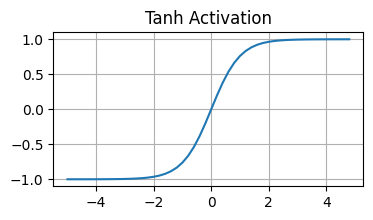

In [5]:
_num = np.arange(-5, 5, 0.2)
plt.figure(figsize=(4, 2))
plt.plot(_num, np.tanh(_num))
plt.title("Tanh Activation")
plt.grid()

##### Calculate Output with Forward Pass

In [26]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass
# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: -0.7071067801767762


##### Calculate Gradient with Backward Pass

w0.grad(i.e. d(output)/d(w0)): -1.500000004284097


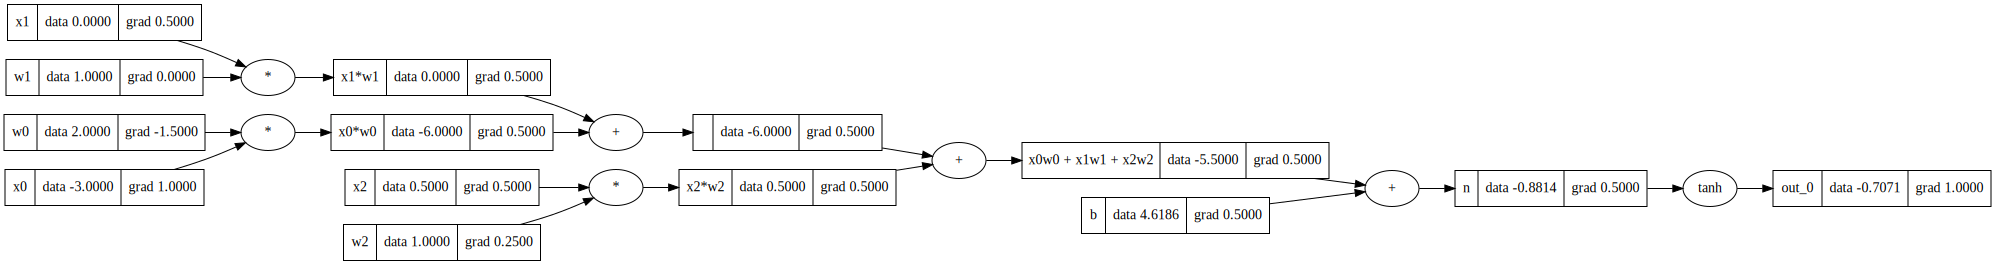

In [7]:
# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
print(f'w0.grad(i.e. d(output)/d(w0)): {w0.grad}')
draw_dot(out_0)

##### Check Backward Pass Gradient Calculation: d(output) / d(x0)

In [8]:
h = 0.000001
w0 += h  # increment x0 by h

# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_1 = n.tanh(); out_1.label = 'out_1'
out_grad = (out_1 - out_0) / h 

print(f'---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----')
print(f'out_1: {out_1.data:<12.10f}, out_0: {out_0.data:<12.10f}, d(out): {out_1.data-out_0.data:<12.10f}, d(w0): {h:<12.10f}, d(out)/d(w0): {(out_1.data-out_0.data)/h:<12.10f}')
print(f'd(out) / d(w0):             {out_grad.data:<12.10f}')
print(f'w0.grad from backward pass: {out_0_grad:<12.10f}')

---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----
out_1: -0.7071082802, out_0: -0.7071067802, d(out): -0.0000015000, d(w0): 0.0000010000, d(out)/d(w0): -1.4999968224
d(out) / d(w0):             -1.4999968224
w0.grad from backward pass: -1.5000000043


##### Check Output and Gradient Calculation with PyTorch

In [27]:
import torch

In [28]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <--')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <--')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <--
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <--


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [29]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [30]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'len(n.parameters()): {len(n.parameters())}')
# n.parameters()
for i, v in enumerate(n.parameters()):
  print(f'i: {i:>2}, {v.data:>14.10f}')

len(n.parameters()): 41
i:  0,  -0.3945857432
i:  1,  -0.1409964153
i:  2,   0.6226040127
i:  3,  -0.3181809031
i:  4,  -0.4004778897
i:  5,  -0.8961484041
i:  6,   0.1601359721
i:  7,   0.7082223884
i:  8,  -0.0626700326
i:  9,  -0.3151682468
i: 10,   0.0002613487
i: 11,  -0.9951387663
i: 12,  -0.8348298522
i: 13,  -0.3751195466
i: 14,   0.1025825745
i: 15,  -0.5674827860
i: 16,   0.5996578973
i: 17,   0.5629428207
i: 18,   0.0957309016
i: 19,   0.1049703976
i: 20,  -0.8963125101
i: 21,   0.4700064321
i: 22,  -0.3382759187
i: 23,   0.2544191880
i: 24,   0.3684811965
i: 25,   0.2396385888
i: 26,  -0.3862843855
i: 27,  -0.3991567509
i: 28,   0.9792600523
i: 29,   0.1860334776
i: 30,   0.4284671868
i: 31,  -0.3388513662
i: 32,   0.9188561337
i: 33,  -0.9841785583
i: 34,   0.9587706546
i: 35,  -0.5827054053
i: 36,   0.1790763345
i: 37,  -0.9123536322
i: 38,  -0.6528384481
i: 39,  -0.9676572871
i: 40,  -0.3552176577


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [31]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [14]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
neuron 0
w0: -0.9001122,   w0.grad:  0.0000000
w1:  0.8099169,   w1.grad:  0.0000000
w2: -0.2057760,   w2.grad:  0.0000000
b:   0.2440071
b_mat:  [0.24400713649289774]
neuron 1
w0: -0.5794287,   w0.grad:  0.0000000
w1: -0.0084990,   w1.grad:  0.0000000
w2: -0.1500628,   w2.grad:  0.0000000
b:   0.3811022
b_mat:  [0.24400713649289774, 0.38110215262010105]
neuron 2
w0: -0.7223584,   w0.grad:  0.0000000
w1:  0.3412714,   w1.grad:  0.0000000
w2: -0.7498457,   w2.grad:  0.0000000
b:  -0.4420290
b_mat:  [0.24400713649289774, 0.38110215262010105, -0.442028987634671]
neuron 3
w0: -0.5543253,   w0.grad:  0.0000000
w1:  0.5264123,   w1.grad:  0.0000000
w2: -0.5791775,   w2.grad:  0.0000000
b:  -0.9234647
b_mat:  [0.24400713649289774, 0.38110215262010105, -0.442028987634671, -0.9234647328431844]
----
layer: 1, neuron_cnt: 4
----
neuron 0
w0:  0.3069117,   w0.grad:  0.0000000
w1: -0.2057734,   w1.grad:  0.0000000
w2:  0.4019992,   w2.grad:  0.0000000
w3: 

##### Print Neural Network's Weights and Biases Matrices

In [15]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat:\n{w_n_b[0]}')
  print(f'b_mat:\n{w_n_b[1]}\n')  
    

i: 0
w_mat:
[[-0.9001122   0.8099169  -0.20577603]
 [-0.57942866 -0.00849905 -0.15006276]
 [-0.72235838  0.34127138 -0.74984566]
 [-0.55432526  0.52641231 -0.57917754]]
b_mat:
[[ 0.24400714  0.38110215 -0.44202899 -0.92346473]]

i: 1
w_mat:
[[ 0.30691166 -0.20577338  0.40199922  0.3206547 ]
 [-0.97235425 -0.0313872  -0.07095789 -0.92928594]
 [-0.47974118  0.5809441  -0.39102622  0.76487519]
 [-0.73359038  0.30040523  0.96743474  0.75440069]]
b_mat:
[[ 0.52239078 -0.3464085  -0.22859017 -0.5960795 ]]

i: 2
w_mat:
[[ 0.21914799 -0.74045405 -0.85716092 -0.41638428]]
b_mat:
[[-0.08533174]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [16]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])
  output = np.tanh(np.matmul(weights, input) + bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')    
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')

--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.9001122   0.8099169  -0.20577603]
 [-0.57942866 -0.00849905 -0.15006276]
 [-0.72235838  0.34127138 -0.74984566]
 [-0.55432526  0.52641231 -0.57917754]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

bias (4, 1):
[[ 0.24400714]
 [ 0.38110215]
 [-0.44202899]
 [-0.92346473]]

output (4, 2):
[[ 0.79294288 -0.99763341]
 [-0.57381323 -0.89037161]
 [-0.11260635 -0.99741684]
 [ 0.12563193 -0.99778575]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.30691166 -0.20577338  0.40199922  0.3206547 ]
 [-0.97235425 -0.0313872  -0.07095789 -0.92928594]
 [-0.47974118  0.5809441  -0.39102622  0.76487519]
 [-0.73359038  0.30040523  0.96743474  0.75440069]]

input (4, 2):
[[ 0.79294288 -0.99763341]
 [-0.57381323 -0.89037161]
 [-0.11260635 -0.99741684]
 [ 0.12563193 -0.99778575]]

bias (4, 1):
[[ 0.52239078]
 [-0.3464085 ]
 [-0.22859017]
 [-0.5960795 ]]

output (4, 2):
[[ 0.70584097 -

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [32]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.5662633528202957, 0.43686528404847547]
ys:                 [1.0, -1.0]
loss_data:          2.2527093236103974


#### Micrograd backward pass and update parameters

In [33]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.3945857432     0.9296913937           0.05000        -0.4410703129
  1     -0.1409964153    -0.3124238009           0.05000        -0.1253752252
  2      0.6226040127     0.1558673546           0.05000         0.6148106450
  3     -0.3181809031     0.3096674340           0.05000        -0.3336642748
  4     -0.4004778897    -2.4280365719           0.05000        -0.2790760611
  5     -0.8961484041     0.8040084102           0.05000        -0.9363488246
  6      0.1601359721    -0.4027319933           0.05000         0.1802725718
  7      0.7082223884    -0.8098307161           0.05000         0.7487139242
  8     -0.0626700326     0.8438263414           0.05000        -0.1048613497
  9     -0.3151682468    -0.2122568470           0.05000        -0.3045554045
 10      0.0002613487     0.1155400508           0.05000        -0.0055156538
 11     -0.9951387663     0.2875498653

### Improve Prediction with Parameter Iteration 

In [34]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.23354024105373464), Value(data = -0.36669129703610936)]
step: 0, loss: 0.9885404753337728
-------
ypred: [Value(data = 0.5038038630991538), Value(data = -0.41793670083479467)]
step: 1, loss: 0.5850082905104066
-------
ypred: [Value(data = 0.5495470888583313), Value(data = -0.5453746375986428)]
step: 2, loss: 0.4095920452945695
-------
ypred: [Value(data = 0.6116207046846927), Value(data = -0.5958094447101566)]
step: 3, loss: 0.31420848201512663
-------
ypred: [Value(data = 0.6512032682386646), Value(data = -0.6367279563507654)]
step: 4, loss: 0.2536257377844804
-------
ypred: [Value(data = 0.681129370484843), Value(data = -0.6681064945099735)]
step: 5, loss: 0.21183177735385075
-------
ypred: [Value(data = 0.7048017368388435), Value(data = -0.6930751305326899)]
step: 6, loss: 0.18134489007088878
-------
ypred: [Value(data = 0.7241254979279003), Value(data = -0.7135251681873724)]
step: 7, loss: 0.1581745701556022
-------
ypred: [Value(data = 0.74027908233464), Val

Text(0, 0.5, 'Loss')

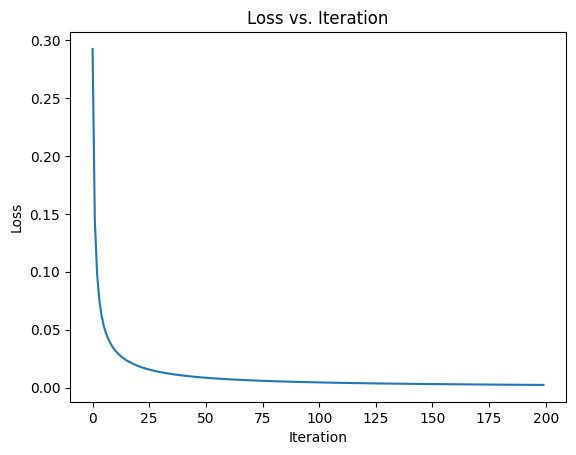

In [20]:

# Create a list of iterations
iterations = range(len(losses))

# Plot the loss as a function of iteration
plt.plot(iterations, losses)

# Add a title to the plot
plt.title('Loss vs. Iteration')

# Add labels to the x-axis and y-axis
plt.xlabel('Iteration')
plt.ylabel('Loss')

# TODO build same model with pyTorch 

In [21]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [5.0, -3.0, 1.5]  
]

# desired targets
ys = [1.0, -1.0, -.5]

# learning rate (i.e. step size)
learning_rate = 0.05